Images in the train set: (60000,)Images in the test set: (10000,)

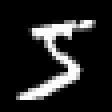

In [6]:
# Loading packages and data
# See: https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition
using Printf, BSON
using ImageView
using Plots

# Load labels and images from Flux.Data.MNIST
# Train set: images used to estimate the CNN
# Load data on gpu (if enabled)
train_labels = gpu.(MNIST.labels(:train))
train_imgs = gpu.(MNIST.images(:train));

# Test set: images used to see how well the CNN perform "out-of-the-sample"
test_imgs = MNIST.images(:test)
test_labels = MNIST.labels(:test)

print("Images in the train set: $(size(train_imgs))")
print("Images in the test set: $(size(test_imgs))")

# Visualization of one digit
NROWS, NCOLS = 28, 28
a = reshape(train_imgs[1], NROWS, NCOLS)

In [7]:
# Model definition
# See: https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl
model = Chain(
    # First convolution, operating upon a 28x28 image
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)), #maxpooling

    # Second convolution, operating upon a 14x14 image
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)), #maxpooling

    # Third convolution, operating upon a 7x7 image
    Conv((3, 3), 32=>32,pad=(1,1), relu),
    MaxPool((2,2)),

    # Reshape 3d tensor into a 2d one, at this point it should be (3, 3, 32, N)
    # which is where we get the 288 in the `Dense` layer below:
    x -> reshape(x, :, size(x, 4)),
    Dense(288, 10),

    # Softmax to get probabilities
    softmax,
)

# Load on gpu (if available)
model = gpu(model);

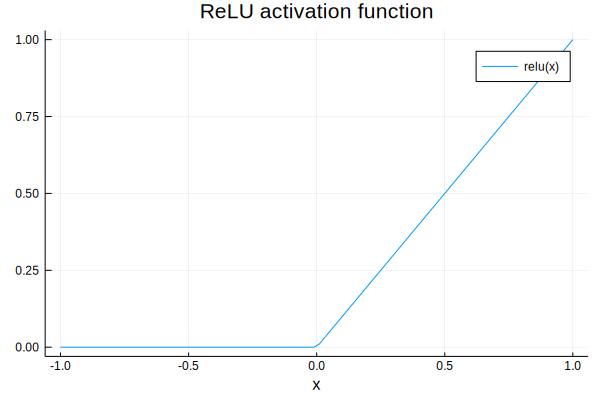

In [8]:
xgrid = collect(range(-1, 1, length=100));
plot(xgrid, NNlib.relu.(xgrid), label = "relu(x)", title="ReLU activation function", xlabel="x")

In [9]:
# Batching 
# See: https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl
# Bundle images together with labels and group into minibatchess
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X[1])..., 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, :, i] = Float32.(X[idxs[i]])
    end
    Y_batch = onehotbatch(Y[idxs], 0:9)
    return (X_batch, Y_batch)
end
# The CNN only "sees" 128 images at each training cycle:
batch_size = 128
mb_idxs = partition(1:length(train_imgs), batch_size)
# train set in the form of batches
train_set = [make_minibatch(train_imgs, train_labels, i) for i in mb_idxs];
# train set in one-go: used to calculate accuracy with the train set
train_set_full = make_minibatch(train_imgs, train_labels, 1:length(train_imgs));
# test set: to check we do not overfit the train data:
test_set = make_minibatch(test_imgs, test_labels, 1:length(test_imgs));

In [10]:
# Loss function
# See: https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl
# `loss()` calculates the crossentropy loss between our prediction `y_hat`
function loss(x, y)
    # Add some noise to the image
    # we reduce the risk of overfitting the train sample by doing so:
    x_aug = x .+ 0.1f0*gpu(randn(eltype(x), size(x)))

    y_hat = model(x_aug)
    return crossentropy(y_hat, y)
end
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

# ADAM optimizer
opt = ADAM(0.001);

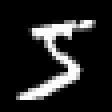

In [11]:
size(train_imgs[1])
train_imgs[1]

In [12]:

(x,y) = train_set[1]
size(x)


(28, 28, 1, 128)

In [29]:
size(y)

(10, 128)

In [13]:
# Training loop
# See: https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl
best_acc = 0.0
last_improvement = 0
accuracy_target = 0.97 #Set an accuracy target. When reached, we stop training.
max_epochs = 100 #Maximum
size(train_set)
for epoch_idx in 1:100
    global best_acc, last_improvement
    # Train for a single epoch
    Flux.train!(loss, params(model), train_set, opt)

    # Calculate accuracy:
    acc = accuracy(train_set_full...)
    println("[%d]: Train accuracy: %.4f", epoch_idx, acc)
    
    # Calculate accuracy:
    acc = accuracy(test_set...)
    println("[%d]: Test accuracy: %.4f", epoch_idx, acc)

    # If our accuracy is good enough, quit out.
    if acc >= accuracy_target
        println(" -> Early-exiting: We reached our target accuracy of $(accuracy_target*100)%")
        break
    end

    if epoch_idx - last_improvement >= 10
        println(" -> We're calling this converged.")
        break
    end
end

[%d]: Train accuracy: %.4f10.9567833333333333
[%d]: Test accuracy: %.4f10.9619
[%d]: Train accuracy: %.4f20.9738166666666667
[%d]: Test accuracy: %.4f20.9754
 -> Early-exiting: We reached our target accuracy of 97.0%


In [14]:
# Get predictions and convert data to Array: 
#pred = Tracker.data(model(test_set[1])); 
pred = model(test_set[1]);
# Function to get the row index of the max value: 
f1(x) = getindex.(argmax(x, dims=1), 1) # Final predicted value is the one with the maximum probability: 
pred = f1(pred) .- 1; #minus 1, because the first digit is 0 (not 1)

In [15]:
println("Predicted value = $(pred[1])") a = reshape(test_imgs[1], NROWS, NCOLS)Predicted value = 7

LoadError: syntax: extra token "a" after end of expression

In [16]:
println("Predicted value = $(pred[2])") a = reshape(test_imgs[2], NROWS, NCOLS)Predicted value = 2

LoadError: syntax: extra token "a" after end of expression

In [19]:
println("Predicted value = $(pred[3])") a = reshape(test_imgs[3], NROWS, NCOLS)Predicted value = 1

LoadError: syntax: extra token "a" after end of expression

In [21]:
pred

1×10000 Array{Int64,2}:
 7  2  1  0  4  1  4  9  5  9  0  6  9  …  5  6  7  8  9  0  1  2  3  4  5  6

In [22]:
test_labels

10000-element Array{Int64,1}:
 7
 2
 1
 0
 4
 1
 4
 9
 5
 9
 0
 6
 9
 ⋮
 5
 6
 7
 8
 9
 0
 1
 2
 3
 4
 5
 6

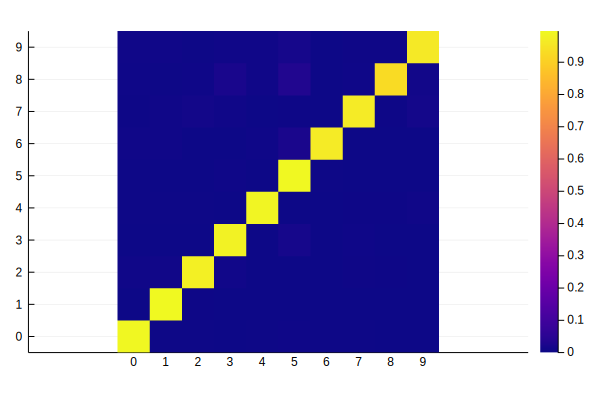

In [24]:
using MLBase # Adding 1 to outcome because the index 0 in arrays does not exist in Julia:
Cm = confusmat(10, test_labels .+ 1, vec(pred) .+ 1)# Normalize output: 
Cm = Cm ./ sum(Cm, dims=2) # Labels 
xs = [string(i) for i = 0:9] 
heatmap(xs, xs, Cm, aspect_ratio=1, color=:plasma)

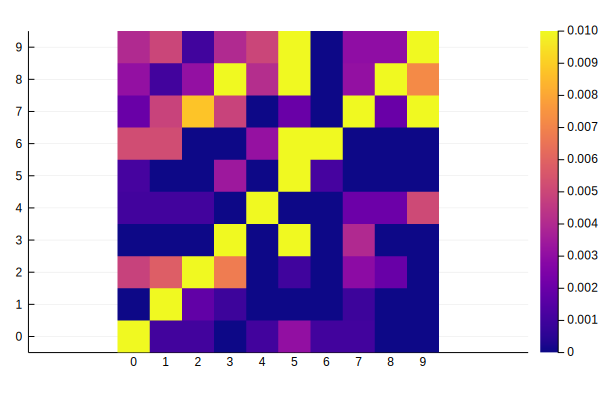

In [25]:
# Limits to colormap, so we can see where errors are located: 
xs = [string(i) for i = 0:9] 
heatmap(xs, xs, Cm, aspect_ratio=1, color=:plasma, clim=(0., 0.01))

In [29]:
using ImageView, Gtk.ShortNames
# indices for errors: 
mistakes = test_labels .!= vec(pred) 
max_images = 5; grid, frames, canvases = canvasgrid((1,max_images));k=0;#counter 
for mistakes for (j, i) in enumerate(mistakes) 
    if i == true k+=1 # a false value has been found 
       println("Predicted value = $(pred[j])") 
       println("True value = $(test_labels[j])") 
       imshow(canvases[1,k], test_imgs[j]) 
    end 
    if k >= max_images 
       break 
    end 
end 
win = Window(grid); 
Gtk.showall(win);
    Predicted value = 5 True value = 9 
Predicted value = 5 True value = 6 
Predicted value = 4 True value = 8 
Predicted value = 3 True value = 2 
Predicted value = 7 True value = 2

LoadError: syntax: invalid iteration specification